## Imports

In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from scipy import sparse
import os
import copy
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap
from skimage.transform import rotate
from shapely.geometry.polygon import Polygon
from argoverse.visualization.visualize_sequences import viz_sequence

In [2]:
## map
am = ArgoverseMap()

##set root_dir to the correct path to your dataset folder
root_dir = '../LaneGCN/dataset/val/data/'
avl = ArgoverseForecastingLoader(root_dir)

## Choose sequence

In [3]:
index = 3
obs_len = 20
seq_path = avl.seq_list[index]
agent_obs_traj = avl.get(seq_path).agent_traj[:obs_len]
city = avl[index].city

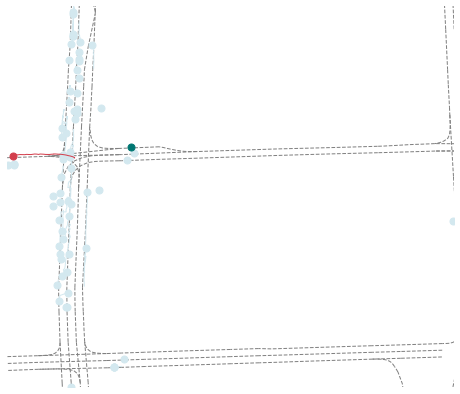

In [4]:
index = 3
seq_path = avl.seq_list[index]
viz_sequence(avl.get(seq_path).seq_df, show=True)

## Get traj object feats

In [67]:
# CHOOSE THE SCENE
idx = 3

# GET THE CITY
city = copy.deepcopy(avl[idx].city)

# START PROCESSING
#-------------------------Arrange given raw information
"""TIMESTAMP,TRACK_ID,OBJECT_TYPE,X,Y,CITY_NAME"""
df = copy.deepcopy(avl[idx].seq_df)

agt_ts = np.sort(np.unique(df['TIMESTAMP'].values))
mapping = dict()
for i, ts in enumerate(agt_ts):
    mapping[ts] = i
    
print("Len of mapping", len(mapping))

trajs = np.concatenate((
            df.X.to_numpy().reshape(-1, 1),
            df.Y.to_numpy().reshape(-1, 1)), 1)
print("Shape of trajs: " , trajs.shape)

steps = [mapping[x] for x in df['TIMESTAMP'].values]
print("Shape of steps ", len(steps))
steps = np.asarray(steps, np.int64)

objs = df.groupby(['TRACK_ID', 'OBJECT_TYPE']).groups # store the frames in which a particular agent is present; 
                                                      # access through keys;

keys = list(objs.keys())
obj_type = [x[1] for x in keys]
print("\nTypes of object in scene: ", obj_type, "\n")
print("Number of objects in scene: ", len(keys))

#-------------------------Get the info of the object of interest
agt_idx = obj_type.index('AGENT')
print("\nAgent Index: ", agt_idx)
idcs = objs[keys[agt_idx]]
print("Which time-steps are the agent present in:", idcs)

agt_traj = trajs[idcs]
agt_step = steps[idcs]

del keys[agt_idx]

#-------------------------Get the other agents info now
ctx_trajs, ctx_steps = [], []
for key in keys:
    idcs = objs[key]
    ctx_trajs.append(trajs[idcs]) # [50, 2]
    ctx_steps.append(steps[idcs])

data = dict()
data['city'] = city
data['trajs'] = [agt_traj] + ctx_trajs # agt of interest-traj is always first in this dict
data['steps'] = [agt_step] + ctx_steps

print("\nTotal no of trajectories stored: ", len(data['trajs']))

Len of mapping 50
Shape of trajs:  (1717, 2)
Shape of steps  1717

Types of object in scene:  ['AV', 'AGENT', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS', 'OTHERS'] 

Number of objects in scene:  70

Agent Index:  1
Which time-steps are the agent present in: Int64Index([   1,   35,   71,  106,  141,  178,  215,  251,  288,  324,  361,
             398,  434,  472,  506,  5

## Given the data, process it: 

1. Center with respect to agent 
2. make sure it has more than 20 steps 
3. make sure it is in the pred-range of 100m

This is the get_item part of the Dataset. This will next be fed to pytorch data loader to batchify. 

In [98]:
#--------------Get origin of the scene
# center
orig = data['trajs'][0][19].copy().astype(np.float32) # copy and astype!
# rot matrix
pre = data['trajs'][0][18] - orig
theta = np.pi - np.arctan2(pre[1], pre[0])
rot = np.asarray([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]], np.float32)

#--------------Start working on getting the centers and feats of the agents
feats, ctrs, gt_preds, has_preds = [], [], [], []

for traj, step in zip(data['trajs'], data['steps']):
    if 19 not in step:
        continue
    
    gt_pred = np.zeros((30, 2), np.float32)
    has_pred = np.zeros(30, np.bool)
    future_mask = np.logical_and(step >= 20, step < 50)
    
    # future GT processing (Note: GT is obviously not normalized w.r.t. origin)
    post_step = step[future_mask] - 20 # can go from 0 to 30; also ends early if no data available
    post_traj = traj[future_mask]
    gt_pred[post_step] = post_traj
    has_pred[post_step] = 1
    
    # get the actual traj data to then model
    obs_mask = step < 20
    step = step[obs_mask]
    traj = traj[obs_mask]
    idcs = step.argsort() # convert [15 16 17 18 19] --->> [0 1 2 3 4]
    step = step[idcs]
    traj = traj[idcs]
    
    for i in range(len(step)):
        if step[i] == 19 - (len(step) - 1) + i:
            break # get only past data
    step = step[i:]
    traj = traj[i:]
    
    feat = np.zeros((20, 3), np.float32)
    feat[step, :2] = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T # re-center w.r.t. origin
    feat[step, 2] = 1.0
    
    x_min, x_max, y_min, y_max = [-100.0, 100.0, -100.0, 100.0]
    if feat[-1, 0] < x_min or feat[-1, 0] > x_max or feat[-1, 1] < y_min or feat[-1, 1] > y_max:
        continue # check if the last feat is within the pred-range
        
    ctrs.append(feat[-1, :2].copy())
    feat[1:, :2] -= feat[:-1, :2] # (input feat: differences between consecutive steps)
    feat[step[0], :2] = 0 # first step=0, no difference registered yet
    
    feats.append(feat)
    gt_preds.append(gt_pred)
    has_preds.append(has_pred)
    
feats = np.asarray(feats, np.float32)
ctrs = np.asarray(ctrs, np.float32)
gt_preds = np.asarray(gt_preds, np.float32)
has_preds = np.asarray(has_preds, np.bool)

data['feats'] = feats
data['ctrs'] = ctrs
data['orig'] = orig
data['theta'] = theta
data['rot'] = rot
data['gt_preds'] = gt_preds
data['has_preds'] = has_preds
data['idx'] = idx